# Dielectric waveguide with scale-invariant effective index

Most dielectric waveguides rely on total internal reflection (TIR) to confine light in the highest index material. Existing options to access lower index materials have limitations like losses, narrow bandwidth, or subwavelength modal size. The research proposed in `Rodrigues, J.R., Dave, U.D., Mohanty, A. et al. All-dielectric scale invariant waveguide. Nat Commun 14, 6675 (2023).`[DOI:10.1038/s41467-023-42234-1](https://doi.org/10.1038/s41467-023-42234-1) demonstrates a new dielectric waveguiding mechanism that confines light in low refractive index materials on a chip. The authors show that at a critical point, the transverse wavevector transitions from imaginary to real, creating an optical mode that is uniform and scale invariant irrespective of geometry. This allows substantial light localization in a low index layer. Using a symmetric SiN/SiON/SiO$_2$ waveguide structure, they experimentally confirm the scale invariance near this critical point. The effective index remains nearly constant even as the waveguide dimensions change. Imaging reveals a non-Gaussian, uniform modal profile unlike a standard waveguide. 

This unusual guiding mode arises from harnessing evanescent waves at the critical point. The proposed mechanism is general and could enable enhanced light-matter interactions, nonlinear effects, and electro-optic modulation by confining light in low index media. The CMOS-compatible demonstration could have important implications for integrated photonics and on-chip light manipulation.

In this notebook, we use `Tidy3D`'s [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html?highlight=modesolver) to investigate the proposed scale invariant waveguide design. Two ways to run the mode solving are demonstrated: via a regular `Tidy3D` [Simulation](../_autosummary/tidy3d.Simulation.html) and via the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/). The result confirms that the effective index of the waveguide mode is nearly constant when the waveguide geometry is changed. In comparison, regular strip waveguide shows a strong dispersion. 

<img src="img/scale_invariant_waveguide.png" width="400" alt="Schematic of the waveguide">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Modes of the Scale-invariant Waveguide

In this notebook, we are only concerned with modes at the wavelength of 1550 nm. 

In [2]:
lda0 = 1.55  # wavelength of interest
freq0 = td.C_0 / lda0  # frequency of interest

The scale-invariant waveguide consists of a medium-index core sandwiched by two high-index layers. The entire waveguide is embedded in a low-index cladding. Here we define the refractive index of the three materials.

In [3]:
n_H = 1.99  # refractive index of the high-index material
n_S = 1.76  # refractive index of the medium-index material
n_L = 1.44  # refractive index of the low-index material

# define medium using the index
mat_H = td.Medium(permittivity=n_H**2)
mat_S = td.Medium(permittivity=n_S**2)
mat_L = td.Medium(permittivity=n_L**2)

The width of the waveguide is kept at 1 $\mu m$. The thickness of the high-index layer is 226 nm. We will investigate the mode properties of the waveguide at various core thicknesses from 0 to 1 $\mu m$.

In [4]:
W = 1  # width of the waveguide
t = 0.226  # thickness of the high-index layer
ds = np.linspace(0, 1, 6)  # thicknesses of the core layer

Define a helper function `make_sim` that takes the core thickness as the input argument, defines the [Structures](../_autosummary/tidy3d.Structure.html), and returns a [Simulation](../_autosummary/tidy3d.Simulation.html). 

Since we are only going to perform mode solving, we are not going to actually run the [Simulation](../_autosummary/tidy3d.Simulation.html) itself. However, the `size`, `grid_spec`, `structures`, `medium`, and `symmetry` properties are going to be used by the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html?highlight=modesolver). The `run_time` is irrelevant so can be set to an arbitrary value. Since we are solving for the fundamental quasi-TE mode and the waveguide geometry is symmetric, we can set `symmetry=(-1,1,0)`. For more information on how to properly use symmetry, refer to our previous [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/).

In [5]:
def make_sim(d):

    dummy_length = 1  # dummy waveguide length in the z direction

    # define structures
    if d > 0:
        top_layer = td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(-W / 2, d / 2, -dummy_length / 2), rmax=(W / 2, d / 2 + t, dummy_length / 2)
            ),
            medium=mat_H,
        )

        bottom_layer = td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(-W / 2, -(d / 2 + t), -dummy_length / 2),
                rmax=(W / 2, -d / 2, dummy_length / 2),
            ),
            medium=mat_H,
        )

        middle_layer = td.Structure(
            geometry=td.Box.from_bounds(
                rmin=(-W / 2, -d / 2, -dummy_length / 2), rmax=(W / 2, d / 2, dummy_length / 2)
            ),
            medium=mat_S,
        )
        structures = [top_layer, bottom_layer, middle_layer]

    else:
        waveguide = td.Structure(geometry=td.Box(size=(W, 2 * t, dummy_length)), medium=mat_H)
        structures = [waveguide]

    # define simulation
    sim = td.Simulation(
        size=(4 * W, 4 * (2 * t + d), dummy_length / 2),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=structures,
        run_time=1e-12,
        medium=mat_L,
        symmetry=(-1, 1, 0),
    )

    return sim

To ensure the simulation is correctly defined, we define one and visualize the permittivity distribution of it. As expected, we see a medium-index core surrounded by two high-index layers in a low-index background.

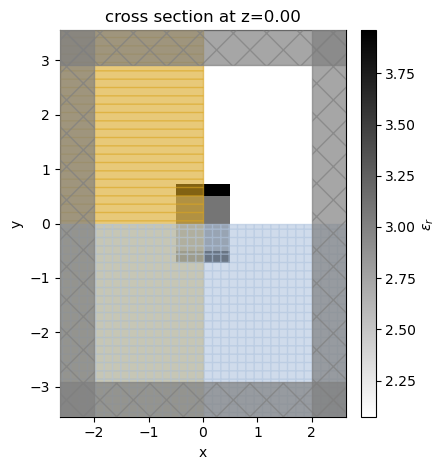

In [6]:
sim = make_sim(ds[5])
sim.plot_eps(z=0)
plt.show()

Since we are going to run the mode solving multiple times for waveguides with different geometries, we define another helper function `solve_mode` to run the mode solver and return the result data. 

In [7]:
def solve_mode(d):

    sim = make_sim(d)  # define a simulation

    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_H)

    # define a mode solver
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(size=(td.inf, td.inf, 0)),
        mode_spec=mode_spec,
        freqs=[freq0],
    )

    # run the mode solver
    mode_data = run_mode_solver(mode_solver, verbose=False)

    return mode_data

Now we are ready to run the mode solving and plot the mode intensity profiles. We will do this in a for loop and solve for the modes of different waveguide geometries. The mode solving results will be stored in a dictionary `results_1` and the effective indices will be stored in an array `n_eff_1`. 

At `d=0 nm`, the waveguide is just a regular strip waveguide. With increasing `d`, the medium-index core layer is getting thicker. We can see that the mode is primarily confined inside the core with a rather uniform field in the vertical direction.

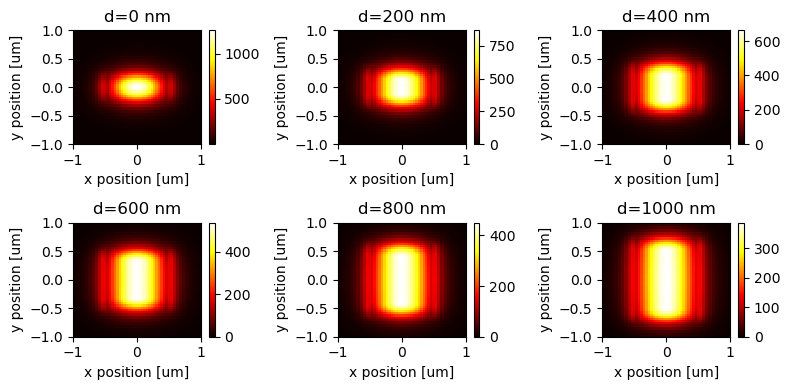

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)

# containers for the effective indices and mode solving results
n_eff_1 = np.zeros(len(ds))
results_1 = {}

for i, d in enumerate(ds):

    # solve for the mode
    mode_data = solve_mode(d)

    # add result to the dictionary
    results_1[f"d={round(d*1e3)} nm"] = mode_data

    # plot mode intensity profile
    row = i // 3
    col = i % 3
    mode_data.intensity.plot(x="x", y="y", cmap="hot", ax=ax[row][col])
    ax[row][col].set_title(f"d={round(d*1e3)} nm")
    ax[row][col].set_xlim(-W, W)
    ax[row][col].set_ylim(-1, 1)
    n_eff_1[i] = mode_data.n_eff.values[0][0]

To quantitively study the mode properties, let's first plot the effective index of the mode as a function of core thickness. We observe that the effective index is nearly constant regardless of the core layer thickness, which confirms the scale-invariant nature of this waveguide design. For more discussions on the mechanism and mathematical details, please refer to the [original publication](https://doi.org/10.1038/s41467-023-42234-1).

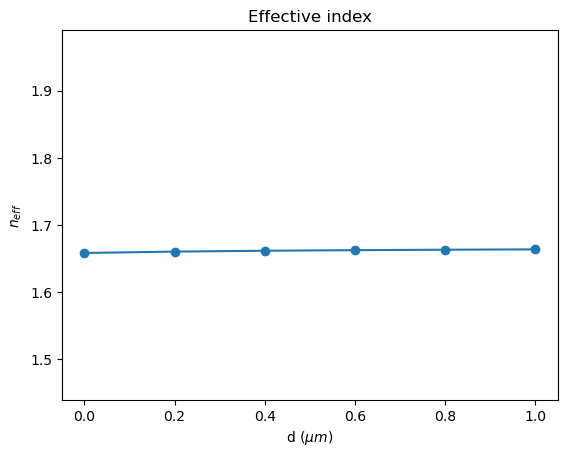

In [9]:
plt.plot(ds, n_eff_1)
plt.scatter(ds, n_eff_1)
plt.ylim(n_L, n_H)
plt.title("Effective index")
plt.xlabel("d ($\mu m$)")
plt.ylabel("$n_{eff}$")
plt.show()

Finally we can investigate the mode profile at `x=0`. We observe a nearly constant field intensity inside the core, which is very distinctive from regular waveguides.

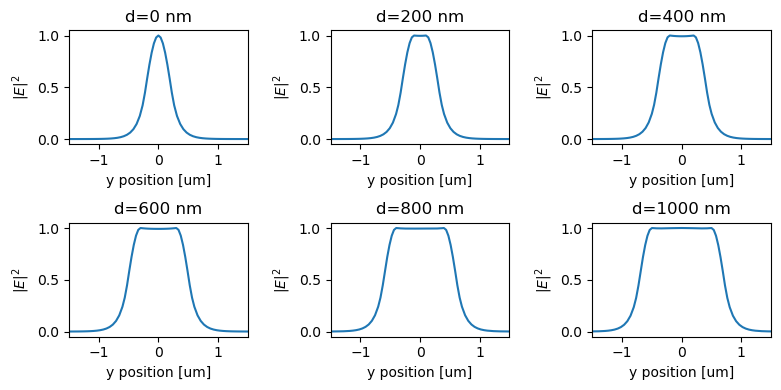

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)

for i, d in enumerate(ds):
    # normalize the intensity profile at x=0
    int_raw = results_1[f"d={round(d*1e3)} nm"].intensity.sel(x=0, method="nearest")
    int_max = np.max(int_raw)
    int_norm = int_raw / int_max

    # plotting
    row = i // 3
    col = i % 3
    int_norm.plot(ax=ax[row][col])
    ax[row][col].set_xlim(-1.5 * W, 1.5 * W)
    ax[row][col].set_title(f"d={round(d*1e3)} nm")
    ax[row][col].set_ylabel("$|E|^2$")

plt.show()

## Modes of the Strip Waveguide

As a comparison, we will perform the same mode analysis for the regular strip waveguide. This time, we demonstrate the use of Tidy3D's [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/), which is a convenient tool for mode analysis on simple waveguides.

First, we solve for the modes and plot their intensity profiles. Here the waveguide thickness is kept the same as the scale-invariant waveguide we showed previously. Note that the waveguide created in the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) is not centered at the origin. Instead, the lower surface of the waveguide is at the $z=0$ plane. As a result, we need to adjust our `ylim` in plotting to ensure the waveguide is centered in our plots. In addition, the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) uses the $yz$ plane for the waveguide cross section while our previous analysis uses the $xy$ plane. This choice is arbitrary but we need to keep that in mind when plotting.

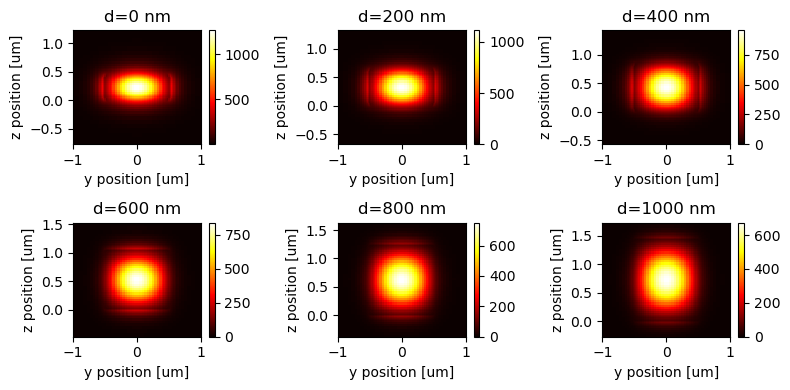

In [11]:
Ts = 2 * t + ds  # total thickness of the waveguide
fig, ax = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)

n_eff_2 = np.zeros(len(Ts))
results_2 = {}

for i, T in enumerate(Ts):

    strip = waveguide.RectangularDielectric(
        wavelength=lda0,
        core_width=W,
        core_thickness=T,
        core_medium=mat_H,
        clad_medium=mat_L,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_H),
        grid_resolution =20,
    )

    mode_data = run_mode_solver(strip.mode_solver, verbose=False)
    results_2[f"d={round(ds[i]*1e3)} nm"] = mode_data

    row = i // 3
    col = i % 3
    mode_data.intensity.plot(x="y", y="z", cmap="hot", ax=ax[row][col])
    ax[row][col].set_title(f"d={round(ds[i]*1e3)} nm")
    ax[row][col].set_xlim(-W, W)
    ax[row][col].set_ylim(-1 + T / 2, 1 + T / 2)
    n_eff_2[i] = mode_data.n_eff.values[0][0]

After running the mode solving for the strip waveguide, we can plot the effective indices for both the strip waveguide and the scale-invariant waveguide. Very distinctively, the regular waveguide shows a strong dispersion when the waveguide geometry is changed, while the scale-invariant waveguide does not.

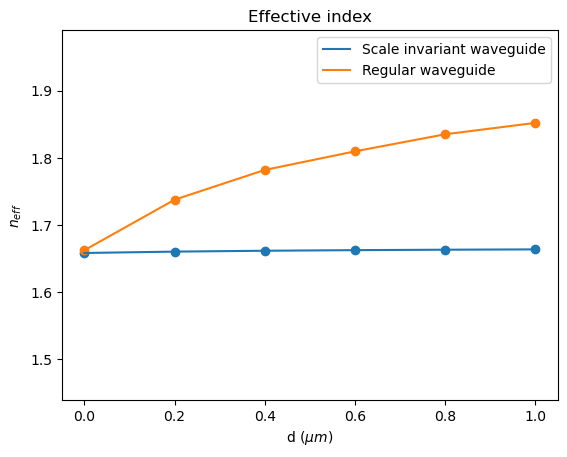

In [12]:
plt.plot(ds, n_eff_1, label="Scale invariant waveguide")
plt.scatter(ds, n_eff_1)

plt.plot(ds, n_eff_2, label="Regular waveguide")
plt.scatter(ds, n_eff_2)

plt.ylim(n_L, n_H)
plt.title("Effective index")
plt.xlabel("d ($\mu m$)")
plt.ylabel("$n_{eff}$")
plt.legend()
plt.show()

Lastly, plot the intensity profiles of the strip waveguide modes. The profile closely follows a Gaussian-like shape besides the small discontinuity at the material interface due to the boundary condition. 

As discussed, the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/) uses the $yz$ plane for the waveguide cross section while our previous analysis uses the $xy$ plane. Therefore, to take the same profile, we will select `y=0` instead of `x=0` while they physically correspond to the same axis with respect to the waveguide. 

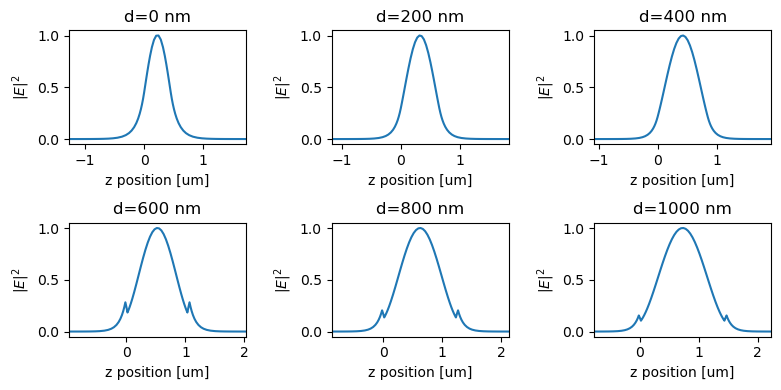

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)

for i, d in enumerate(ds):
    int_raw = results_2[f"d={round(d*1e3)} nm"].intensity.sel(y=0, method="nearest")
    int_max = np.max(int_raw)
    int_norm = int_raw / int_max

    row = i // 3
    col = i % 3

    int_norm.plot(ax=ax[row][col])
    ax[row][col].set_xlim(-1.5 * W + t + d / 2, 1.5 * W + t + d / 2)
    ax[row][col].set_title(f"d={round(d*1e3)} nm")
    ax[row][col].set_ylabel("$|E|^2$")

plt.show()